<div style="text-align: center;">

# The Geometry of Learning: Curvature, Orthogonality and Computational Cost

</div>

**Notebook:** `CDM_4_Final.ipynb`

**Project Goal:** Investigate the **mathematical** and **computational foundations** of optimization in neural networks. We focus on **Curvature** (Newton/CG), **Scalability** (Hessian Memory), and **Geometric Conditioning** (QR).

-----

### Abstract:

1.  **Mathematical Analysis:** Implementing **Gradient Descent (GD)**, **Newton's Method**, and **Conjugate Gradient (CG)** from scratch on ill-conditioned surfaces.
2.  **Newtonian Space:** Using `scipy.optimize` to benchmark **Stochastic Gradient Descent (SGD)**, **CG**, and **Limited-memory BFGS (L-BFGS)** on a shallow neural network with real-time loss tracking.
3.  **The Scale Trap:** Analyzing the massive **Hessian memory requirements** for Deep Models (using the MNIST dataset).
4.  **Orthogonality:** Using **QR decomposition** on the **Boston Housing** dataset to perfect the conditioning and accelerate Gradient Descent.

In [1]:
# -----------------------------------------------------------
# Core Libraries
# -----------------------------------------------------------
import numpy as np                 # Numerical operations
import matplotlib.pyplot as plt    # Visualization
import time                        # Timing operations
from scipy.optimize import minimize  # Optimization routines

# -----------------------------------------------------------
# Machine Learning & Datasets
# -----------------------------------------------------------
from sklearn.datasets import load_breast_cancer, fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# -----------------------------------------------------------
# Deep Learning
# -----------------------------------------------------------
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import torch
import torch.nn as nn
import torch.optim as optim

# -----------------------------------------------------------
# Plotting Configuration
# -----------------------------------------------------------
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.style.use('ggplot')

# -----------------------------------------------------------
# Suppress Warnings
# -----------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [2]:
# -----------------------------------------------------------
# Define the Cost Function and Derivatives
# -----------------------------------------------------------
# H is a diagonal matrix with high condition number (50/1)
H = np.array([[1.0, 0.0], 
              [0.0, 50.0]])

def cost_func(theta):
    """Quadratic cost: J = 0.5 * theta^T * H * theta"""
    return 0.5 * theta.T @ H @ theta

def gradient(theta):
    """Gradient: del_J = H * theta"""
    return H @ theta

def hessian(theta):
    """Hessian: H"""
    return H

In [3]:
# -----------------------------------------------------------
# Implement Optimizers (GD, Newton, CG)
# -----------------------------------------------------------

def run_optimizer(start_pos, steps, mode='gd', lr=0.03):
    """
    Runs optimization algorithms from scratch.
    
    Args:
        mode: 'gd' (Gradient Descent), 'newton' (Newton), 'cg' (Conjugate Gradient)
    """
    theta = start_pos.copy()
    path = [theta.copy()]
    
    # Variables needed for Conjugate Gradient
    d = None  # Search direction
    r = None  # Residual (negative gradient)
    
    for i in range(steps):
        grad = gradient(theta)
        
        if mode == 'gd':
            # Standard Update
            update = -lr * grad
            
        elif mode == 'newton':
            # Newton Update: H^-1 * g
            H_inv = np.linalg.inv(hessian(theta))
            update = -H_inv @ grad
            
        elif mode == 'cg':
            # Linear Conjugate Gradient Logic for Quadratic Form
            if i == 0:
                d = -grad
                r = -grad
            else:
                # Polak-Ribiere / Fletcher-Reeves beta
                # For quadratic, beta = (r_new.T @ r_new) / (r_old.T @ r_old)
                r_new = -grad
                beta = (r_new.T @ r_new) / (r.T @ r)
                d = r_new + beta * d
                r = r_new
            
            # Optimal Step Size (alpha) for quadratic: (r.T * r) / (d.T * H * d)
            # Note: Using 'd' as direction
            alpha = (r.T @ r) / (d.T @ H @ d)
            update = alpha * d
            
        # Apply update
        theta = theta + update
        path.append(theta.copy())
        
    return np.array(path)

# -----------------------------------------------------------
# Run Comparisons
# -----------------------------------------------------------
start_point = np.array([5.0, 3.0])

# 1. Gradient Descent: Tuned iterations/lr to ensure convergence visualization
path_gd = run_optimizer(start_point, steps=60, mode='gd', lr=0.038)

# 2. Newton's Method: Converges instantly on quadratic
path_newton = run_optimizer(start_point, steps=2, mode='newton')

# 3. Conjugate Gradient: Should converge in 2 steps for 2D quadratic
path_cg = run_optimizer(start_point, steps=3, mode='cg')

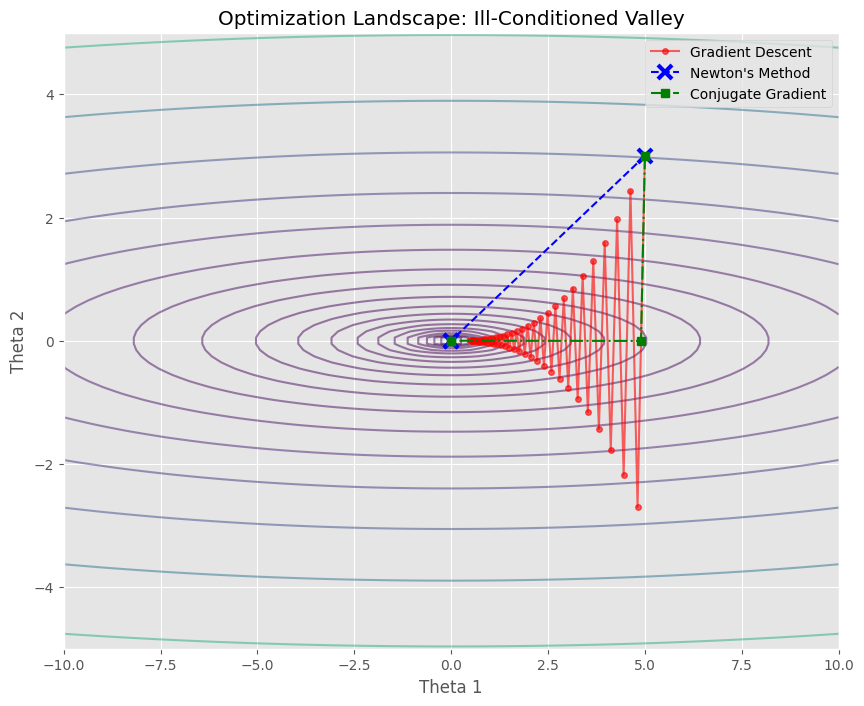

In [4]:
# -----------------------------------------------------------
# Visualization
# -----------------------------------------------------------
x_range = np.linspace(-10, 10, 100)
y_range = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        vec = np.array([X[i, j], Y[i, j]])
        Z[i, j] = cost_func(vec)

plt.figure(figsize=(10, 8))
plt.contour(X, Y, Z, levels=np.logspace(-1, 3, 20), cmap='viridis', alpha=0.5)

plt.plot(path_gd[:, 0], path_gd[:, 1], 'o-', label='Gradient Descent', color='red', markersize=4, alpha=0.6)
plt.plot(path_newton[:, 0], path_newton[:, 1], 'x--', label="Newton's Method", color='blue', markersize=10, markeredgewidth=3)
plt.plot(path_cg[:, 0], path_cg[:, 1], 's-.', label="Conjugate Gradient", color='green', markersize=6)

plt.title('Optimization Landscape: Ill-Conditioned Valley')
plt.xlabel('Theta 1')
plt.ylabel('Theta 2')
plt.legend()
plt.show()

In [5]:
# -----------------------------------------------------------
# Data Preparation
# -----------------------------------------------------------
data = load_breast_cancer()
X, y = data.data, data.target

# Standardize (Crucial for second-order methods)
scaler = StandardScaler()

# Add bias term to X directly to simplify manual matrix multiplication
X = np.c_[X, np.ones(X.shape[0])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

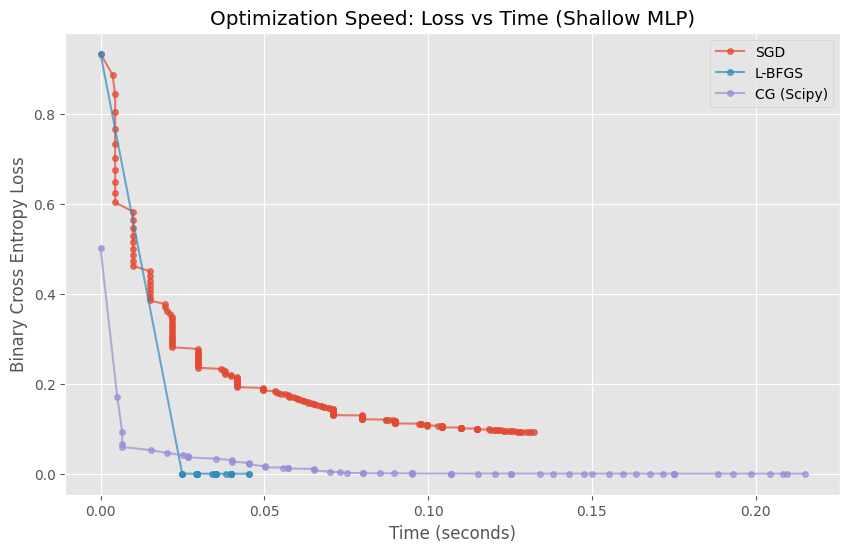

In [6]:
# -----------------------------------------------------------
# Shallow MLP & Optimization Comparison
# -----------------------------------------------------------

# Convert data to PyTorch tensors
X_t = torch.FloatTensor(X_train)
y_t = torch.FloatTensor(y_train)

# Define Shallow MLP (Input: 31, Hidden: 5, Output: 1)
# Total Params: (31*5 + 5) + (5*1 + 1) = 166 < 500
def get_model():
    return nn.Sequential(
        nn.Linear(31, 5),
        nn.Tanh(),
        nn.Linear(5, 1),
        nn.Sigmoid()
    )

# Shared Initialization to ensure same starting point
start_model = get_model()
init_weights = start_model.state_dict()
criterion = nn.BCELoss()

results = {}

# ---------------------------------------------------------
# 1. SGD (PyTorch)
# ---------------------------------------------------------
model_sgd = get_model()
model_sgd.load_state_dict(init_weights)
opt_sgd = optim.SGD(model_sgd.parameters(), lr=0.05)

times_sgd, losses_sgd = [], []
start = time.time()

for _ in range(200):
    opt_sgd.zero_grad()
    y_pred = model_sgd(X_t)
    loss = criterion(y_pred, y_t)
    loss.backward()
    opt_sgd.step()
    
    times_sgd.append(time.time() - start)
    losses_sgd.append(loss.item())

results['SGD'] = (times_sgd, losses_sgd)

# ---------------------------------------------------------
# 2. L-BFGS (PyTorch - Approximate Newton)
# ---------------------------------------------------------
model_lbfgs = get_model()
model_lbfgs.load_state_dict(init_weights)
opt_lbfgs = optim.LBFGS(model_lbfgs.parameters(), lr=1, max_iter=20)

times_lbfgs, losses_lbfgs = [], []
start = time.time()

def closure():
    opt_lbfgs.zero_grad()
    loss = criterion(model_lbfgs(X_t), y_t)
    loss.backward()
    return loss

# L-BFGS performs multiple evaluations per step, we track steps
for _ in range(25): 
    loss = opt_lbfgs.step(closure)
    times_lbfgs.append(time.time() - start)
    losses_lbfgs.append(loss.item())

results['L-BFGS'] = (times_lbfgs, losses_lbfgs)

# ---------------------------------------------------------
# 3. Conjugate Gradient (Scipy via PyTorch Bridge)
# ---------------------------------------------------------
model_cg = get_model()
model_cg.load_state_dict(init_weights)

# Helpers to flatten/unflatten parameters for Scipy
def get_flat_params(model):
    return np.concatenate([p.data.numpy().ravel() for p in model.parameters()])

def set_flat_params(model, flat_params):
    offset = 0
    for p in model.parameters():
        numel = p.numel()
        p.data = torch.from_numpy(flat_params[offset:offset+numel]).view_as(p).float()
        offset += numel

def scipy_objective(flat_params):
    set_flat_params(model_cg, flat_params)
    model_cg.zero_grad()
    loss = criterion(model_cg(X_t), y_t)
    loss.backward()
    grads = np.concatenate([p.grad.numpy().ravel() for p in model_cg.parameters()])
    return loss.item(), grads.astype(np.float64)

times_cg, losses_cg = [], []
start = time.time()

def cg_callback(xk):
    # Evaluate current loss for plotting
    loss, _ = scipy_objective(xk)
    times_cg.append(time.time() - start)
    losses_cg.append(loss)

# Run Scipy Minimize with CG
minimize(scipy_objective, get_flat_params(model_cg), method='CG', jac=True, callback=cg_callback, options={'maxiter': 60})

results['CG (Scipy)'] = (times_cg, losses_cg)

# ---------------------------------------------------------
# Plotting
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))
for name, (t, l) in results.items():
    # Shift time to start at 0
    t_shifted = np.array(t) - t[0]
    plt.plot(t_shifted, l, 'o-', label=name, markersize=4, alpha=0.7)

plt.title('Optimization Speed: Loss vs Time (Shallow MLP)')
plt.xlabel('Time (seconds)')
plt.ylabel('Binary Cross Entropy Loss')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# -----------------------------------------------------------
# Define Deep Model
# -----------------------------------------------------------
def create_deep_model():
    model = models.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(100, activation='relu'),
        layers.Dense(100, activation='relu'),
        layers.Dense(100, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

model = create_deep_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,710 (389.49 KB)

 Trainable params: 99,710 (389.49 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# -----------------------------------------------------------
# Hessian Memory Calculation
# -----------------------------------------------------------
N = model.count_params()
hessian_elements = N ** 2
memory_gb = (hessian_elements * 4) / (1024**3) # 4 bytes per float32

print(f"\nTotal Parameters (N): {N:,}")
print(f"Hessian Matrix Size (NxN): {hessian_elements:,} elements")
print(f"RAM Required for Full Hessian: {memory_gb:.2f} GB")
print("Conclusion: Storing/Inverting this matrix is computationally infeasible.")


Total Parameters (N): 99,710
Hessian Matrix Size (NxN): 9,942,084,100 elements
RAM Required for Full Hessian: 37.04 GB
Conclusion: Storing/Inverting this matrix is computationally infeasible.


Training with SGD...
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5123 - loss: 1.6485 - val_accuracy: 0.9022 - val_loss: 0.3797
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8862 - loss: 0.4059 - val_accuracy: 0.9225 - val_loss: 0.2758
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9110 - loss: 0.3141 - val_accuracy: 0.9342 - val_loss: 0.2330
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9197 - loss: 0.2761 - val_accuracy: 0.9400 - val_loss: 0.2083
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9295 - loss: 0.2461 - val_accuracy: 0.9435 - val_loss: 0.1904
Training with Adam...
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8368 - loss: 0.5434 - val_accuracy: 0.9552 - val_loss: 0.1439
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9616 - loss: 0.1267 - val_accuracy: 0.9717 - val_loss: 0.0991
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.973

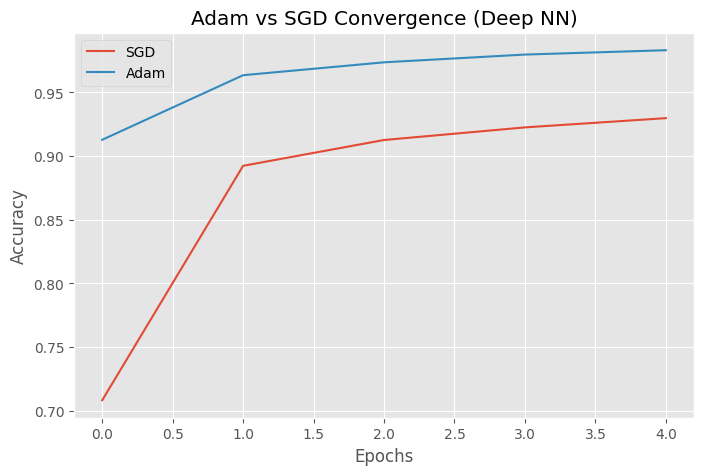

In [9]:
# -----------------------------------------------------------
# Training: Adam vs SGD
# -----------------------------------------------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.0

opt_dict = {
    'SGD': optimizers.SGD(learning_rate=0.01),
    'Adam': optimizers.Adam(learning_rate=0.001)
}

hist_acc = {}

for name, opt in opt_dict.items():
    print(f"Training with {name}...")
    m = create_deep_model()
    m.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    h = m.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)
    hist_acc[name] = h.history['accuracy']

plt.figure(figsize=(8, 5))
for name, acc in hist_acc.items():
    plt.plot(acc, label=name)
plt.title('Adam vs SGD Convergence (Deep NN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

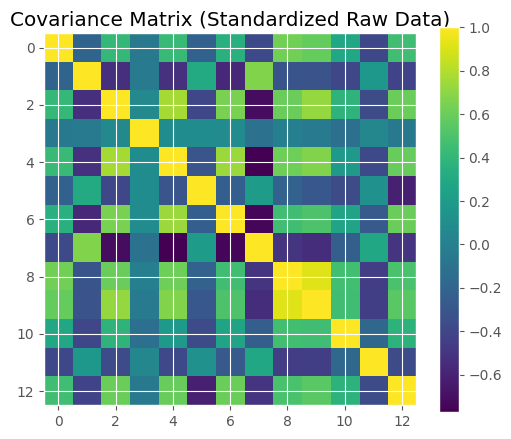

In [10]:
# -----------------------------------------------------------
# Load Boston Housing Data
# -----------------------------------------------------------
# Loading from OpenML since it's deprecated in sklearn
boston = fetch_openml(name='boston', version=1, as_frame=True)
X = boston.data.values
y = boston.target.values.astype(np.float64).reshape(-1, 1)

# Standardize first (Important for Linear Regression GD)
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Visualize Covariance Matrix (Raw Features)
plt.figure(figsize=(6, 5))
plt.imshow(np.cov(X_std.T))
plt.title("Covariance Matrix (Standardized Raw Data)")
plt.colorbar()
plt.show()

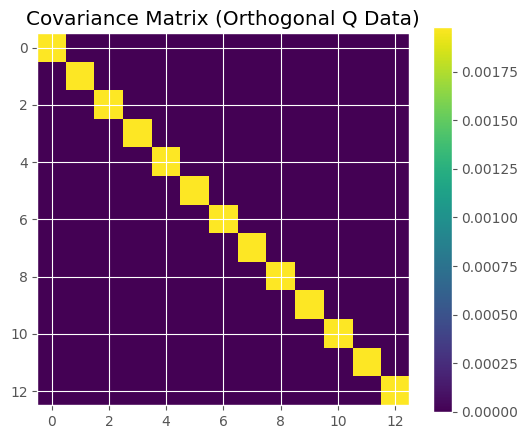

In [ ]:
# -----------------------------------------------------------
# QR Decomposition – Orthogonalization
# -----------------------------------------------------------
# X_std = Q * R  →  Columns of Q are orthogonal
Q, R = np.linalg.qr(X_std)

# Visualize Covariance of Q (Should be close to Identity)
plt.figure(figsize=(6, 5))
plt.imshow(np.cov(Q.T))
plt.title("Covariance Matrix (Orthogonal Q Data)")
plt.colorbar()
plt.show()

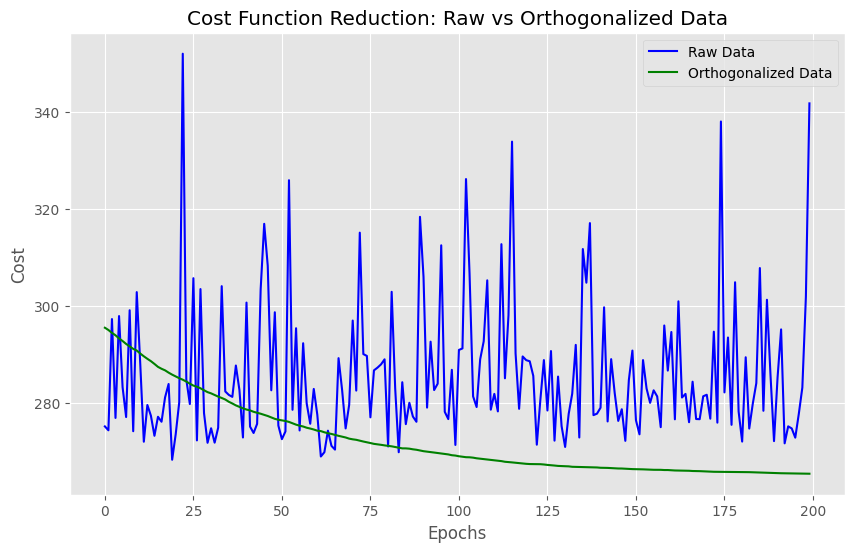

In [12]:
# -----------------------------------------------------------
# Linear Regression with SGD: Raw vs Orthogonalized Data
# -----------------------------------------------------------

# Define the cost function for linear regression
def compute_cost(X, y, weights):
    m = len(y)
    predictions = X @ weights
    cost = (1 / (2 * m)) * np.sum((predictions - y) ** 2)
    return cost

# Implement SGD for linear regression
def sgd_linear_regression(X, y, lr=0.01, epochs=100):
    m, n = X.shape
    weights = np.zeros((n, 1))
    cost_history = []

    for _ in range(epochs):
        for i in range(m):
            idx = np.random.randint(0, m)
            xi = X[idx, :].reshape(1, -1)
            yi = y[idx]
            gradient = xi.T @ (xi @ weights - yi)
            weights -= lr * gradient

        cost = compute_cost(X, y, weights)
        cost_history.append(cost)

    return weights, cost_history

# Train on raw data
weights_raw, cost_history_raw = sgd_linear_regression(X_std, y, lr=0.01, epochs=200)

# Train on orthogonalized data
weights_orthogonal, cost_history_orthogonal = sgd_linear_regression(Q, y, lr=0.01, epochs=200)

# Plot the cost history for both cases
plt.figure(figsize=(10, 6))
plt.plot(cost_history_raw, label='Raw Data', color='blue')
plt.plot(cost_history_orthogonal, label='Orthogonalized Data', color='green')
plt.title('Cost Function Reduction: Raw vs Orthogonalized Data')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.show()